# Mountain Car

In [1]:
# Loading LegoRL library
import sys
sys.path.append('..\\LegoRL')  # path to folder with library

from LegoRL import *

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import torch
import torch.nn as nn
import gym

# Environment and network

In [3]:
import gym

class MountainCarLogger(gym.Wrapper):
    def step(self, a):
        s, r, d, info = self.env.step(a)
        
        self.max_height = max(self.max_height, self.h(s[0]))
        info["max_height"] = self.max_height
        
        return s, r, d, info
    
    def h(self, xs):
        return np.sin(3 * xs)*.45+.55
        
    def reset(self):
        s = self.env.reset()
        self.max_height = self.h(s[0])
        return s

In [4]:
def make_env():
    def _thunk():
        env = gym.make('MountainCar-v0')
        env = MountainCarLogger(env)
        return env
    return _thunk

# Network

In [5]:
MountainCarNN = lambda input_size, output_size: nn.Sequential(
                            nn.Linear(input_size, 20),
                            nn.ReLU(),
                            nn.Linear(20, 20),
                            nn.ReLU(),
                            nn.Linear(20, output_size))

# Algorithm

In [8]:
agent = Composed(
    player          = Player(policy="q_head", timer=2500, record_timer=25000),
    visualizer      = Visualizer(),
    q_head          = QualityHead(network=MountainCarNN, representation=Quantile(Q, num_atoms=11)),
    policy          = eGreedy(greedy_policy="q_head", epsilon_decay=100000),
    runner          = Runner(policy="policy", threads=8, timer=8, log_info=[("max_height", "max height")], env_max_T=200),
    replay          = ReplayBuffer(runner="runner", capacity=100000),
    sampler         = Sampler(replay="replay"),
    target_head     = Frozen(QualityHead)(source="q_head"),
    target          = OneStep(evaluator="target_head"),
    critic_loss     = CriticLoss(sampler="sampler", critic="q_head", target="target"),
    trainer         = Trainer(transformations=["q_head"], losses=["critic_loss"],
                             optimizer_args={"lr": 1e-3}),
)

In [9]:
system = System(agent, make_env=make_env, folder_name="Models\\MountainCar QR-DQN", save_timer=10000)

Initializing <q_head>:
  Input shape is torch.Size([2])
  Output shape is torch.Size([11, 3])
runner: environment initialization... Finished.
Initializing <target_head>:
  Input shape is torch.Size([2])
  Output shape is torch.Size([3])


In [10]:
#system.load()

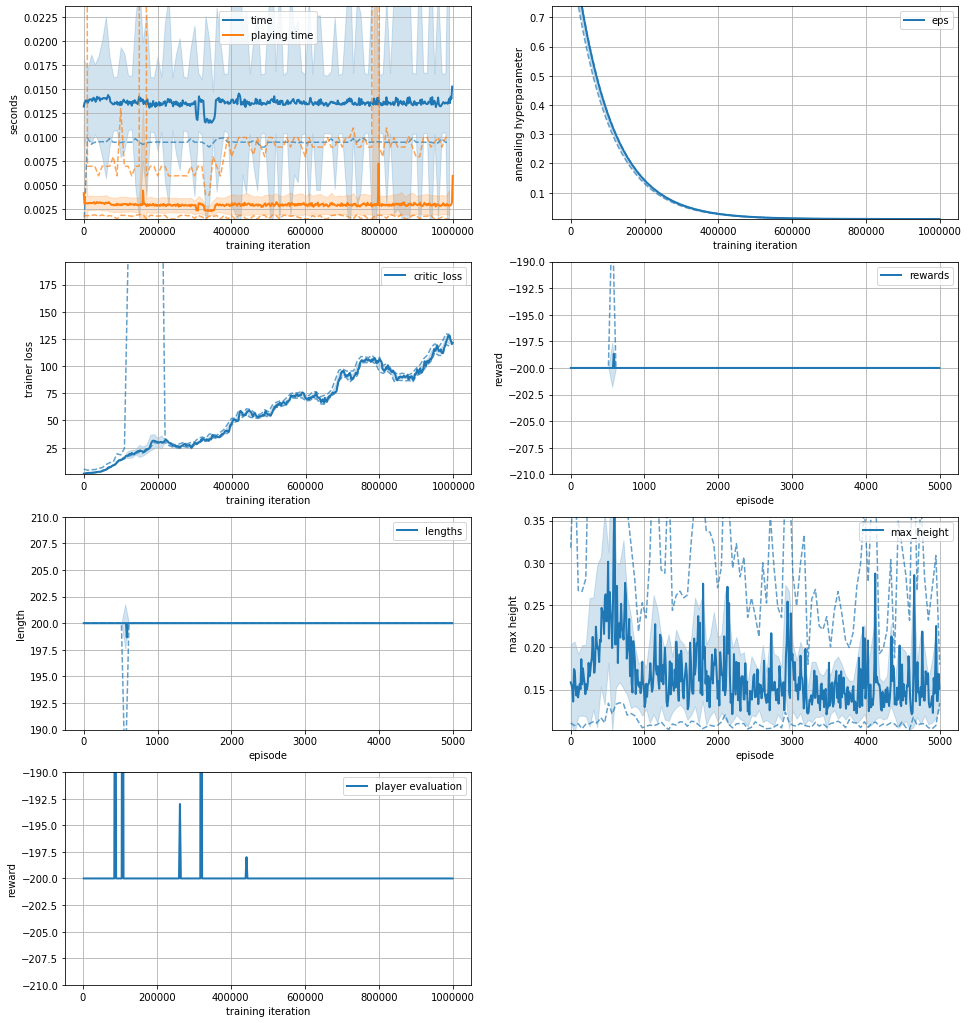

In [11]:
system.run(1000000)

In [12]:
print("Learning time in hours: ", system.wallclock() / 60 / 60)
print("Frames done: ", agent.runner.frames_done)
print("Fps: ", agent.runner.fps)
print("Episodes played: ", agent.runner.episodes_done)

Learning time in hours:  3.7739932257599302
Frames done:  1000000
Fps:  73.60314689538016
Episodes played:  5000


Text(0.5, 0, 'episode')

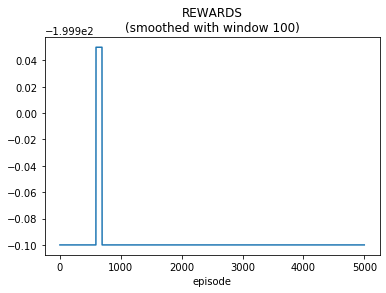

In [13]:
from LegoRL.utils.visualizer import sliding_average
plt.plot(sliding_average(system.logger['rewards'], 100))
plt.title("REWARDS\n(smoothed with window 100)")
plt.xlabel("episode")